# Rough Notebook to be changed to pct reduction
## Last Updated: 10-25-2020

In [93]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
import json
import warnings
from os import listdir
from os.path import isfile,join
import datetime
import requests
from sklearn.metrics import r2_score, accuracy_score
import catboost
import matplotlib as mpl
import sys
sys.path.append('.')
from src.utils import collect_data
from src.utils import eda


In [94]:
import importlib
importlib.reload(collect_data)
collect_datasets = collect_data.DataCollection()
data_analysis = eda.DataAnalysis()

In [95]:
df_mobility = collect_datasets.get_mobility_data()
df_county_spending = collect_datasets.get_spend_data()
df_covid = collect_datasets.combine_covid_data()
df_weather = collect_datasets.combine_weather(df_mobility,df_covid)
df_county = collect_datasets.combined_county_data()

In [96]:
def get_model_df(df_weather, df_mob,df_covid,df_demographics,covid=False):
    df_mob = df_mob.dropna()
    covid_date = datetime.datetime.strptime('2020-03-15', '%Y-%m-%d')
    if covid:
        df_mob_prep = pd.merge(left = df_mob, right = df_covid, on = ['fips', 'date'], how='inner')
        df_mob_prep = df_mob_prep[df_mob_prep.date >covid_date]
    else:
        st_date = covid_date - datetime.timedelta(days=366)
        end_date = df_mob.date.max() - datetime.timedelta(days=365)
        df_mob_prep = df_mob[(df_mob.date < end_date)&(df_mob.date >= st_date)]
        
    df_mob_covid_weather = pd.merge(left = df_mob_prep, right = df_weather, on =['date', 'fips'])
    df_all = pd.merge(left = df_mob_covid_weather.drop(columns=['State Postal Code', 'Level']), 
                      right = df_demographics, on = ['fips'])
    df_all['party'] =df_all['party'].fillna('republican')
    return df_all

In [6]:
def run_model_tt(df,name,target_var,remove_col_list,task_type='GPU',max_depth= 6):
    
    remove_cols = ['fips','COUNTY','YEAR','NAME_E' ] + remove_col_list
    
    df_final = df.drop(columns=remove_cols)
    df_final = df_final.dropna()
    X =df_final.drop(columns=[target_var])
    y =df_final[[target_var]]
    date_test = df_final.date.max() - datetime.timedelta(days=14)
    X_train, X_test, y_train, y_test = X[X.date <= date_test],X[X.date > date_test], y[X.date <= date_test],y[X.date > date_test]
    X_train = X_train.drop(columns=['date'])
    X_test = X_test.drop(columns=['date'])

    
    cat_index = [X_train.columns.get_loc("STATE"),X_train.columns.get_loc("weekday"),X_train.columns.get_loc("month"),
                 X_train.columns.get_loc("weekend"),X_train.columns.get_loc("party")]
    cb_model = catboost.CatBoostRegressor(task_type=task_type, n_estimators=200, eval_metric='R2',
                                      max_depth=max_depth,devices='0',learning_rate=0.2,
                                          verbose=200,cat_features=cat_index)
    cb_model.fit(X_train,y_train)
    y_pred_cb = cb_model.predict(X_test)
    print(np.round(r2_score(y_test,y_pred_cb),2))
    test = y_test.values.flatten()
    plt.scatter(y_test,(test-y_pred_cb)*100/test,s=2)
    plt.yscale('symlog')
    plt.xscale('log')
    plt.xlabel('y_true')
    plt.ylabel('Error (%)')
    plt.ylim(-500,500)
    plt.show()
    df_cb_feat_imp =  pd.DataFrame(cb_model.feature_importances_, X_train.columns,columns=[name +'_Covid_Feature_Importance'])
    return df_cb_feat_imp,y_test,y_pred_cb


0:	learn: 0.1338656	total: 349ms	remaining: 1m 9s
199:	learn: 0.7589102	total: 1m 5s	remaining: 0us
0.48


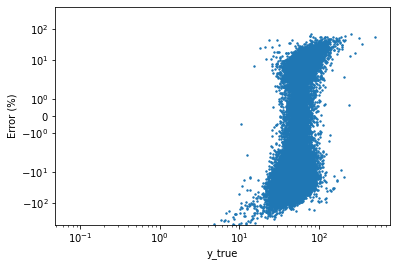

Pre_Covid_Feature_Importance
STATE                                                                  12.480419
Median Household Income in the Past 12 Months (...                      5.937800
Travel Time to Work_90 or more minutes                                  2.791281
Sex by Age_Female 25 to 29 years                                        2.336555
pct_republican                                                          2.314890
Travel Time to Work_60 to 89 minutes                                    1.946235
Race_Asian alone                                                        1.920723
Gross Rent as a Percentage of Household Income ...                      1.817238
Travel Time to Work_15 to 19 minutes                                    1.705518
Travel Time to Work_45 to 59 minutes                                    1.617146
Means of Transportation to Work_Worked at home                          1.595788
Travel Time to Work_30 to 34 minutes                                    1.491434
Means of Transportation to Work_Car, truck, or ...                      1.445852
Gross Rent as a Percentage of Household Income ...                      1.380679
Sex by Age_Male 50 to 54 years                                          1.343775
Gross Rent as a Percentage of Household Income ...                      1.230235
Public Assistance Income or Food Stamps/SNAP in...                      1.229140
month                                                                   1.213175
Household Income in the Past 12 Months (in 2018...                      1.196683
Race_Black or African American alone                                    1.162929

In [13]:
target_var = 'mobility_per_person'
keep_cols = ['weekday','weekend','month'] + [target_var]
df_mob_train_pre = get_model_df(df_weather, df_mobility,df_covid,df_county)
remove_col_list = [col for col in df_mobility.columns if col in df_mob_train_pre and col not in keep_cols]
remove_col_list.remove('date')

df_mob_pre_feat_imp,y_test,y_pred_cb = run_model_tt(df_mob_train_pre,'Pre', target_var,remove_col_list,task_type='CPU',max_depth = 8)
df_mob_pre_feat_imp.sort_values('Pre_Covid_Feature_Importance',ascending=False)[:20]

In [ ]:
def run_model(df,name,target_var,remove_col_list,task_type='GPU',max_depth= 6):
    
    remove_cols = ['date','fips','COUNTY','YEAR','NAME_E' ] + remove_col_list
    
    df_final = df.drop(columns=remove_cols)
    df_final = df_final.dropna()
    X =df_final.drop(columns=[target_var])
    y =df_final[[target_var]]
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
    cat_index = [X.columns.get_loc("STATE"),X.columns.get_loc("weekday"),
                 X.columns.get_loc("weekend"),X.columns.get_loc("party")]
    cb_model = catboost.CatBoostRegressor(task_type=task_type, n_estimators=1000, eval_metric='RMSE',
                                      max_depth=max_depth,devices='0',learning_rate=0.35,
                                          verbose=200,cat_features=cat_index)
    cb_model.fit(X_train,y_train)
    y_pred_cb = cb_model.predict(X_test)
    print(np.round(r2_score(y_test,y_pred_cb),2))
    test = y_test.values.flatten()
    plt.scatter(y_test,(test-y_pred_cb)*100/test,s=2)
    plt.yscale('symlog')
    plt.xscale('log')
    plt.xlabel('y_true')
    plt.ylabel('Error (%)')
    plt.ylim(-500,500)
    plt.show()
    df_cb_feat_imp =  pd.DataFrame(cb_model.feature_importances_, X_train.columns,columns=[name +'_Covid_Feature_Importance'])
    return df_cb_feat_imp,y_test,y_pred_cb


In [ ]:
target_var = 'mobility_per_person'
keep_cols = ['weekday','weekend'] + [target_var]
df_mob_train_pre = get_model_df(df_weather, df_mobility,df_covid,df_county)
remove_col_list = [col for col in df_mobility.columns if col in df_mob_train_pre and col not in keep_cols]

df_mob_pre_feat_imp,y_test,y_pred_cb = run_model(df_mob_train_pre,'Pre', target_var,remove_col_list,task_type='CPU',max_depth = 8)
df_mob_pre_feat_imp.sort_values('Pre_Covid_Feature_Importance',ascending=False)[:20]

Total Rows Test Dataset 42577 ||| Records with over 200% error 68


error_pct  Count
STATE                                 
Alaska               -23.431307    348
Montana              -19.582129    624
Mississippi          -19.455072   1134
North Dakota         -18.397794    610
District of Columbia -17.717880     14
Hawaii               -17.429987     56
Wyoming              -16.397623    316
Idaho                -15.779268    579
Nevada               -15.088946    225
Nebraska             -15.038848   1055
South Dakota         -15.007659    782
Alabama              -14.766857    938
Arkansas             -14.724170   1050
Missouri             -13.621709   1595
West Virginia        -13.570504    770
Oklahoma             -13.543827   1073
Connecticut          -13.475668    112
Arizona              -13.351922    210
Kansas               -13.179122   1366
Iowa                 -12.792732   1384
Texas                -12.683304   3343
South Carolina       -12.588842    644
Georgia              -12.239049   2211
Indiana              -12.213097   1288
Utah                 -12.002066    378
Vermont              -11.712417    196
Louisiana            -11.551658    896
Massachusetts        -11.389512    196
Tennessee            -11.315094   1330
Illinois             -11.126776   1419
Wisconsin            -10.676733   1007
New Mexico           -10.540461    432
Kentucky             -10.337611   1670
Colorado             -10.098469    817
Oregon                -9.985474    483
California            -9.933333    792
Delaware              -9.879880     42
Maryland              -9.748717    336
Virginia              -9.652703   1848
Florida               -9.266102    938
New Hampshire         -9.242431    140
Ohio                  -9.237348   1232
Michigan              -9.160372   1156
Pennsylvania          -8.769868    938
North Carolina        -8.502147   1399
Maine                 -8.321659    224
Minnesota             -8.271575   1218
Washington            -7.946941    531
Rhode Island          -7.505174     70
New York              -7.301913    868
New Jersey            -7.007031    294

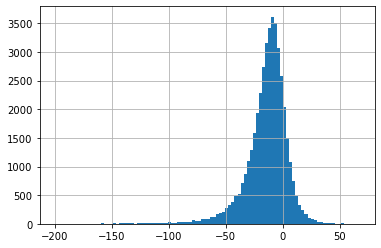

In [14]:
pd.options.mode.chained_assignment = None
y_test['pred']= y_pred_cb
y_test['error_pct'] = (y_test[target_var] - y_test.pred)*100/y_test[target_var]
test_data = df_mob_train_pre.loc[y_test.index]
test_data['error_pct'] = y_test['error_pct']
y_test.error_pct[abs(y_test.error_pct)<200].hist(bins=100)
print('Total Rows Test Dataset',len(y_test),'||| Records with over 200% error',
      len(y_test[abs(y_test.error_pct)>200]))
pd.concat([test_data.groupby(['STATE'])['error_pct'].median(),
           test_data.groupby(['STATE'])['error_pct'].count().rename('Count')], 
           axis=1).sort_values('error_pct')

In [12]:
def get_rgb_col(x):
    import matplotlib
    color = plt.get_cmap("plasma")
    rgb=  color.colors[x][:3]
    return str(matplotlib.colors.rgb2hex(rgb))

In [81]:
df_mobility

Level       date State Postal Code   fips  \
0        County 2019-01-01                MO  29171   
1        County 2019-01-01                AL  01001   
2        County 2019-01-01                AL  01003   
3        County 2019-01-01                AL  01005   
4        County 2019-01-01                AL  01007   
...         ...        ...               ...    ...   
2016272  County 2020-10-10                AL  01011   
2016273  County 2020-10-10                AL  01013   
2016274  County 2020-10-10                AL  01015   
2016275  County 2020-10-10                AL  01017   
2016276  County 2020-10-10                AL  01019   

         Population Staying at Home  Population Not Staying at Home  \
0                            1155.0                          3587.0   
1                            9624.0                         45807.0   
2                           44415.0                        172941.0   
3                            4782.0                         20023.0   
4                            3861.0                         18471.0   
...                             ...                             ...   
2016272                      1568.0                          8570.0   
2016273                      3634.0                         16046.0   
2016274                     27605.0                         86672.0   
2016275                      8523.0                         25092.0   
2016276                      5053.0                         20979.0   

         Number of Trips  Number of Trips <1  Number of Trips 1-3  \
0                12429.0              2807.0               3642.0   
1               132004.0             27097.0              35263.0   
2               534520.0            120752.0             142931.0   
3                67658.0             15524.0              16677.0   
4                54827.0             11602.0              15874.0   
...                  ...                 ...                  ...   
2016272          26306.0              4295.0               3108.0   
2016273          49222.0              9097.0              11617.0   
2016274         284673.0             52745.0              76064.0   
2016275          83586.0             15611.0              22234.0   
2016276          62284.0              6153.0               9565.0   

         Number of Trips 3-5  ...   weekday  weekend    month     Wk #  \
0                     1272.0  ...   Tuesday  Weekday  January   1 2019   
1                    18315.0  ...   Tuesday  Weekday  January   1 2019   
2                    68235.0  ...   Tuesday  Weekday  January   1 2019   
3                    10550.0  ...   Tuesday  Weekday  January   1 2019   
4                     7590.0  ...   Tuesday  Weekday  January   1 2019   
...                      ...  ...       ...      ...      ...      ...   
2016272               2334.0  ...  Saturday  Weekend  October  41 2020   
2016273               5400.0  ...  Saturday  Weekend  October  41 2020   
2016274              37289.0  ...  Saturday  Weekend  October  41 2020   
2016275              10915.0  ...  Saturday  Weekend  October  41 2020   
2016276              10761.0  ...  Saturday  Weekend  October  41 2020   

         mobility_per_trip  mobility_per_person  pct_stay_home  \
0                13.704079            35.919022      24.356811   
1                11.785605            28.066371      17.362126   
2                10.826448            26.624308      20.434219   
3                11.121390            30.334650      19.278371   
4                12.597561            30.928108      17.289092   
...                    ...                  ...            ...   
2016272          24.721337            64.146725      15.466561   
2016273          16.241518            40.621951      18.465447   
2016274          12.064558            30.053764      24.156217   
2016275          12.425956            30.897992      25.354752   
2016276          15.173849            36.304856     

In [123]:
def get_pct_changes(df1,df2,col):
    x1 = df1.groupby(['fips','Wk #'])[col].mean().sort_values()
    x2 = df2.groupby(['fips','Wk #'])[col].mean().sort_values()
    df = pd.concat([x1,x2],axis=1).reset_index()
    cols = ['fips', 'Wk #', col +'_pre',col +'_COVID']
    df.columns = cols
    targ_var = 'pct_change_'+col
    df[targ_var] =( df[cols[2]]- df[cols[3]]) / df[cols[2]]
    df = df.fillna(df.mean())
    df[targ_var][df[targ_var]<0] =0
    min_val = (df[targ_var].min())
    max_val = (df[targ_var].max())
    col_scl = 255 / (abs(min_val) + abs(max_val))
    df['color'] = (((df[targ_var]) - abs(min_val)) * col_scl).astype(int)
    df['color'] = df['color'].apply(lambda x: get_rgb_col(x))
    df['date'] = '2020-'  + df['Wk #'].astype(str) 
    df['date'] = df["date"].apply(lambda x: datetime.datetime.strptime(x + '-1', "%Y-%W-%w"))
    df.date = (df['date'].astype('int64')//1e9).astype('U10')
    df['opacity'] = 0.75 #MinMaxScaler().fit_transform(x.pct_change_mob.values.reshape(-1,1))
    return df

In [125]:
df_mob_train_pre = get_model_df(df_weather, df_mobility,df_covid,df_county)
df_mob_train_covid = get_model_df(df_weather, df_mobility,df_covid,df_county,covid=True)

x = get_pct_changes(df_mob_train_pre,df_mob_train_covid,col= 'mobility_per_person')
x

fips Wk #  mobility_per_person_pre  mobility_per_person_COVID  \
0      01001   11                41.506609                  45.340726   
1      01001   12                44.265117                  34.079652   
2      01001   13                46.044465                  29.514929   
3      01001   14                44.296099                  28.103946   
4      01001   15                45.427047                  26.369223   
...      ...  ...                      ...                        ...   
97230  56045   37               187.557937                 117.622988   
97231  56045   38               173.194439                 123.466762   
97232  56045   39               177.952542                 114.575581   
97233  56045   40               140.283771                  96.447825   
97234  56045   41               154.737295                 129.925422   

       pct_change_mobility_per_person    color          date  opacity  
0                            0.202989  #6e00a8  1584316800.0     0.75  
1                            0.230101  #7a02a8  1584921600.0     0.75  
2                            0.358991  #a82296  1585526400.0     0.75  
3                            0.365544  #ab2494  1586131200.0     0.75  
4                            0.419526  #bb3488  1586736000.0     0.75  
...                               ...      ...           ...      ...  
97230                        0.372871  #ac2694  1600041600.0     0.75  
97231                        0.287121  #8f0da4  1600646400.0     0.75  
97232                        0.356145  #a72197  1601251200.0     0.75  
97233                        0.312481  #9814a0  1601856000.0     0.75  
97234                        0.160348  #5c01a6  1602460800.0     0.75  

[97235 rows x 8 columns]

In [126]:
import geopandas as gpd
df_geo = gpd.read_file('./Data/geometry/county.geojson', driver='GeoJSON')

df_geo['GEO_ID'] = df_geo['GEO_ID'].astype(str).str[-5:]
df_geo

GEO_ID STATE COUNTY          NAME    LSAD  CENSUSAREA  \
0     01001    01    001       Autauga  County     594.436   
1     01009    01    009        Blount  County     644.776   
2     01017    01    017      Chambers  County     596.531   
3     01021    01    021       Chilton  County     692.854   
4     01033    01    033       Colbert  County     592.619   
...     ...   ...    ...           ...     ...         ...   
3216  51001    51    001      Accomack  County     449.496   
3217  51021    51    021         Bland  County     357.725   
3218  51027    51    027      Buchanan  County     502.763   
3219  51037    51    037     Charlotte  County     475.271   
3220  51041    51    041  Chesterfield  County     423.297   

                                               geometry  
0     POLYGON ((-86.49677 32.34444, -86.71790 32.402...  
1     POLYGON ((-86.57780 33.76532, -86.75914 33.840...  
2     POLYGON ((-85.18413 32.87053, -85.12342 32.772...  
3     POLYGON ((-86.51734 33.02057, -86.51596 32.929...  
4     POLYGON ((-88.13999 34.58170, -88.13925 34.587...  
...                                                 ...  
3216  MULTIPOLYGON (((-75.24227 38.02721, -75.29687 ...  
3217  POLYGON ((-81.22510 37.23487, -81.20477 37.243...  
3218  POLYGON ((-81.96830 37.53780, -81.92787 37.512...  
3219  POLYGON ((-78.44332 37.07940, -78.49303 36.891...  
3220  POLYGON ((-77.85180 37.35487, -77.85515 37.418...  

[3221 rows x 7 columns]

In [153]:
def get_style_dict(df,df_geo):
    def get_state_id(x,sdict):
            if x in sdict.keys():
                return sdict[x]
            else:
                return None
    sdict = df_geo.reset_index().set_index('GEO_ID')['index'].to_dict()

    df['id'] = (df['fips'].apply(lambda x:get_state_id(x,sdict)))
    df = df.dropna()
    df['id'] = df['id'].astype(int)
    styledata = {}
    for st in df.id.unique():
        df_st = df[df.id==st][['date','color','opacity']].sort_values('date').set_index('date')
        styledata[st] = df_st
    styledict = {
    str(country): data.to_dict(orient='index') for
    country, data in styledata.items()}
    return styledict

In [154]:
from branca.element import MacroElement
from jinja2 import Template
class BindColormap(MacroElement):
    """Binds a colormap to a given layer.

    Parameters
    ----------
    colormap : branca.colormap.ColorMap
        The colormap to bind.
    """
    def __init__(self, layer, colormap):
        super(BindColormap, self).__init__()
        self.layer = layer
        self.colormap = colormap
        self._template = Template(u"""
        {% macro script(this, kwargs) %}
            {{this.colormap.get_name()}}.svg[0][0].style.display = 'block';
            {{this._parent.get_name()}}.on('overlayadd', function (eventLayer) {
                if (eventLayer.layer == {{this.layer.get_name()}}) {
                    {{this.colormap.get_name()}}.svg[0][0].style.display = 'block';
                }});
            {{this._parent.get_name()}}.on('overlayremove', function (eventLayer) {
                if (eventLayer.layer == {{this.layer.get_name()}}) {
                    {{this.colormap.get_name()}}.svg[0][0].style.display = 'none';
                }});
        {% endmacro %}
        """)  # noqa

In [151]:
def generate_ts_geo(styledict,df,targ_var,name):
#     base_map = folium.Map(location=us_cen, zoom_start=4,tiles='cartodbpositron')

    g = TimeSliderChoropleth(
    df_geo.to_json(),
    styledict=styledict,name=name)
    color = plt.get_cmap("plasma")
    from matplotlib.colors import rgb2hex
    min_color = rgb2hex(color.colors[0][:3])
    mid_color = rgb2hex(color.colors[127][:3])
    max_color = rgb2hex(color.colors[-1][:3])
    from branca.colormap import LinearColormap

    min_val = (df[targ_var].min())
    max_val = (df[targ_var].max())
    color_scale = LinearColormap([min_color, mid_color, max_color],
                                         vmin=min_val,
                                         vmax=max_val)
    return g,color_scale

In [169]:
import folium
import warnings
warnings.filterwarnings('ignore')
import time
from folium.plugins import TimeSliderChoropleth
import os
from IPython.display import IFrame

us_cen = [43.8283, -98.5795]
cols = [col for col in df_mobility.columns[-6:] if col not in ['Max_Trip_Type','pct_not_home']]
for col in cols:
    base_map = folium.Map(location=us_cen, zoom_start=4,tiles='cartodbpositron')
    
    x = get_pct_changes(df_mob_train_pre,df_mob_train_covid,col= col)
    styledict = get_style_dict(x,df_geo)

    targ_var = 'pct_change_' + col
    g,color_scale = generate_ts_geo(styledict,x,targ_var,name=col)

    fpath = '../' + col + '.html'
    base_map.add_child(g)
    
    base_map.add_child(color_scale)
    base_map.add_child(BindColormap(g, color_scale))
#     gmap = folium.GeoJson(
#             data=df_geo.to_json(),
#             style_function=lambda feature: {
#                 'fillColor': 'white',
#                 'fillOpacity': 0,
#                 'color': 'black',
#                 'weight': 0.5,
#             }
#         )
#     base_map.add_child(gmap)
    base_map.add_child(folium.map.LayerControl())
    base_map.save(fpath)

    display(IFrame(src=fpath, width=1000, height=1000))
    input('Press Enter to Continue')
    os.remove(fpath)
    clear_output()

In [431]:
from folium.plugins import TimeSliderChoropleth

styledict = get_style_dict(x,df_geo)
cols = [col for col in df_mobility.columns[-6:] if col!='Max_Trip_Type']
g = TimeSliderChoropleth(
    df_geo.to_json(),
    styledict=styledict).add_to(base_map)
min_color = rgb2hex(color.colors[0][:3])
mid_color = rgb2hex(color.colors[127][:3])
max_color = rgb2hex(color.colors[-1][:3])
color_scale = LinearColormap([min_color, mid_color, max_color],
                                     vmin=min_val,
                                     vmax=max_val)
base_map.add_child(color_scale)
base_map

In [135]:
import matplotlib
def get_color(map_dict, feature):
    color = plt.get_cmap("plasma")
    min_val = min(map_dict.values())
    max_val = max(map_dict.values())
    if isinstance(min_val, datetime.datetime):
        color_sc = 255 / (max_val - min_val).days
        value = int((map_dict.get(feature['properties']['STATE']) - (min_val)).days * color_sc)
    else:
        color_sc = 255 / (abs(min_val) + abs(max_val))
        value = int((map_dict.get(feature['properties']['STATE']) + abs(min_val)) * color_sc)
    rgb = color.colors[value][:3]
    return str((matplotlib.colors.rgb2hex(rgb)))

0:	learn: 0.1675480	total: 337ms	remaining: 1m 7s
199:	learn: 0.8094619	total: 1m 1s	remaining: 0us
0.63


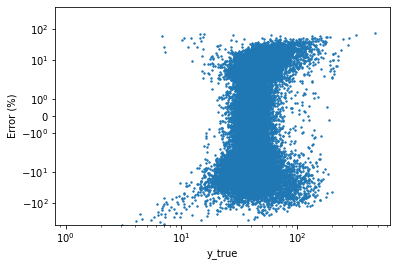

Post_Covid_Feature_Importance
month                                                                   10.164617
Travel Time to Work_Total                                                7.009087
STATE                                                                    5.776587
Gross Rent as a Percentage of Household Income ...                       3.480577
Median Household Income in the Past 12 Months (...                       2.757336
Household Income in the Past 12 Months (in 2018...                       2.237825
Public Assistance Income or Food Stamps/SNAP in...                       2.221780
Means of Transportation to Work_Total                                    1.871794
Household Income in the Past 12 Months (in 2018...                       1.801927
Race_Total                                                               1.779879
Sex by Age_Total                                                         1.643962
Means of Transportation to Work_Car, truck, or van                       1.490335
pct_republican                                                           1.354711
Household Income in the Past 12 Months (in 2018...                       1.340621
weekend                                                                  1.306367
Sex by Age_Female 85 years and over                                      1.271725
Sex by Age_Female 70 to 74 years                                         1.231448
Means of Transportation to Work_Worked at home                           1.163330
Travel Time to Work_90 or more minutes                                   1.069820
Means of Transportation to Work_Car, truck, or ...                       0.980483
Sex by Age_Male 5 to 9 years                                             0.959050
Sex by Age_Male                                                          0.955441
Race_Asian alone                                                         0.941446
weekday                                                                  0.927412
Sex by Age_Female 62 to 64 years                                         0.904048

In [17]:
df_mob_train_covid = get_model_df(df_weather, df_mobility,df_covid,df_county,covid=True)
remove_col_list_COVID = [col for col in df_mobility.columns if col in df_mob_train_covid and col not in keep_cols]
remove_col_list_COVID.remove('date')
remove_col_list_COVID.extend(['Lat','Lng'])
df_mob_covid_feat_imp,y_test,y_pred_cb = run_model_tt(df_mob_train_covid,'Post', target_var,remove_col_list_COVID,task_type='CPU',max_depth = 8)
df_mob_covid_feat_imp.sort_values('Post_Covid_Feature_Importance',ascending=False)[:25]

In [ ]:
y_test['pred'] = y_pred_cb
y_test['error_pct'] = (y_test[target_var] - y_test.pred)*100/y_test[target_var]
test_data = df_mob_train_covid.loc[y_test.index]
test_data['error_pct'] = y_test['error_pct']
y_test.error_pct[abs(y_test.error_pct)<200].hist(bins=100)
print('Total Rows Test Dataset',len(y_test),'||| Records with over 200% error',
      len(y_test[abs(y_test.error_pct)>200]))
pd.concat([test_data.groupby(['STATE'])['error_pct'].median(),
           test_data.groupby(['STATE'])['error_pct'].count().rename('Count')], 
           axis=1).sort_values('error_pct')